# Results Checker for Bets

In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import warnings

warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

directory = 'C:/Users/99451/Desktop/MODEL/2025/dixon_coles_model_predictions/_bets.xlsx'
predictions = pd.read_excel(directory)
predictions['League'] = predictions['League'].str.capitalize()
predictions.rename(columns = {'HomeTeam':'Home', 'AwayTeam':'Away'}, inplace = True)

predictions.tail()

,League,Home,Away,Rec,RecPer,RecOdd,RecVal,DCBets,DCPercent,DCOdd,DCVal,FTRBets,FTRPercent,FTROdd,FTRVal,2.5O/U,2.5Percent,2.5Odd,2.5Val,BTTS,BTPercent,BTOdd,BTVal
703,Poland,Widzew Łódź,Korona Kielce,FT1,75.80,2.07,0.75,DC1X,91.56,1.30,0.21,FT1,75.80,2.07,0.75,2.5U,53.16,1.88,0.00,OTTS,67.66,2.07,0.59
704,Portugal,Rio Ave,Famalicão,FT2,58.30,2.48,0.76,DCX2,90.93,1.44,0.34,FT2,58.30,2.48,0.76,2.5U,80.24,1.57,0.32,OTTS,79.93,1.78,0.53
705,Spain,Leganés,Valencia,FTX,63.70,2.70,1.13,DC1X,92.99,1.41,0.33,FTX,63.70,2.70,1.13,2.5U,85.30,2.30,1.13,OTTS,65.91,1.58,0.06
706,Spain2,Huesca,Cadiz,FT1,59.83,3.00,1.33,DC12,85.49,1.47,0.30,FT1,59.83,3.00,1.33,2.5O,53.00,1.67,-0.22,OTTS,51.36,1.53,-0.42
707,Turkey,Çaykur Rizespor,Antalyaspor A.Ş.,FT2,66.52,3.45,1.95,DCX2,94.92,1.74,0.69,FT2,66.52,3.45,1.95,2.5U,61.45,1.76,0.13,OTTS,66.31,1.94,0.43


# Finding Game Results

In [2]:
final =  pd.DataFrame()
liqa = ''
unique_leagues = predictions['League'].unique().tolist()

for i in unique_leagues:
    URL = "https://www.soccerstats.com/results.asp?league=" + i + "&pmtype=bydate"
    page = requests.get(URL)
    liqa = i
    soup = BeautifulSoup(page.content, "html.parser")
    results = soup.find(id="btable")
    sth = results.find_all("tr", class_="odd")
    sth


    date, league, home, away, ft, ht = [], [], [], [], [],[]
    for i in sth:
        date.append(i.find_all("td", align = 'right')[0].get_text(strip=True))
        league.append(liqa.capitalize())
        home.append(i.find_all("td", align = 'right')[1].get_text(strip=True))
        away.append(i.find("td", align = "left").get_text(strip = True))
        ft.append(i.find_all("td", align = 'center')[0].get_text(strip = True))
        try:
            ht.append(i.find_all("td", align = 'center')[2].get_text(strip = True))
        except IndexError as e:
            ht.append('NA')#print("Last output before error occurred:", i.find_all("td", align = 'center'))

    data = {'Date': date, 'League': league,'Home': home, 'Away': away, 'FT': ft, 'HT': ht}

# Create a DataFrame from the dictionary
    df = pd.DataFrame(data)

# Replace empty strings with NaN
    #next_df = df[(df['Date'] == formatted_date) & (df['HT'] == '')]
    df.replace('', pd.NA, inplace=True)

# Drop rows with NaN values
    df_cleaned = df.dropna()

#For Half-Time Results
    hthg, htag = [], []
    for i in df_cleaned['HT']:
        if i == 'NA':
            hthg.append('NA')
            htag.append('NA')
        elif i == '+' or i == '-':
            hthg.append('NA')
            htag.append('NA')
        else:
            try:
                hthg.append(int(i[1]))
                htag.append(int(i[3]))
            except IndexError as e:
                print("Last output before error occurred:", i)



#For Full-Time Results
    hg, ag, tg = [], [], []
    for i in df_cleaned['FT']:
        if len(i) < 5 or ':' in i:
            hg.append('NA')
            ag.append('NA')
            tg.append('NA')
        else:
            try:
                hghg = int(i.split(' - ')[0])
                hg.append(hghg)
                agag = int(i.split(' - ')[1])
                ag.append(agag)
                tg.append(hghg + agag)
            except:
                print(hghg + agag)

    
    df_cleaned['FTHG'], df_cleaned['FTAG'], df_cleaned['FTTG'] = hg, ag, tg
    df_cleaned['HTHG'], df_cleaned['HTAG'] = hthg, htag
    df_cleaned['HTTG'] = df_cleaned['HTHG'] + df_cleaned['HTAG']
    
    final = pd.concat([final, df_cleaned], ignore_index=True)
    
final = final[final['HT'] != 'NA']

# Example: Fix the 'date' column by removing the weekday and extra punctuation
final['Date'] = final['Date'].str.extract(r'(\d{1,2} \w{3})')  # Extract day and month part
final['Date'] = final['Date'] + ' 2024'  # Append the year

# Convert to datetime format
final['Date'] = pd.to_datetime(final['Date'], format='%d %b %Y', errors='coerce')

# Filter rows before September 6th, 2024
final_filtered = final[final['Date'] >= pd.Timestamp('2024-09-06')]
combined = pd.concat([final_filtered.head(), final_filtered.tail()])

combined

,Date,League,Home,Away,FT,HT,FTHG,FTAG,FTTG,HTHG,HTAG,HTTG
39,2024-09-13,Spain,Real Betis,Leganes,2 - 0,(0-0),2,0,2,0,0,0
40,2024-09-14,Spain,Mallorca,Villarreal,1 - 2,(0-1),1,2,3,0,1,1
41,2024-09-14,Spain,Espanyol,Alaves,3 - 2,(1-1),3,2,5,1,1,2
42,2024-09-14,Spain,Sevilla FC,Getafe,1 - 0,(1-0),1,0,1,1,0,1
43,2024-09-14,Spain,Real Sociedad,Real Madrid,0 - 2,(0-0),0,2,2,0,0,0
3998,2024-09-28,Germany,Wolfsburg,Stuttgart,2 - 2,(1-1),2,2,4,1,1,2
3999,2024-09-28,Germany,Bayern Munich,Leverkusen,1 - 1,(1-1),1,1,2,1,1,2
4000,2024-09-29,Germany,Holstein Kiel,E. Frankfurt,2 - 4,(1-1),2,4,6,1,1,2
4001,2024-09-29,Germany,Hoffenheim,Werder Bremen,3 - 4,(3-3),3,4,7,3,3,6
4002,2024-10-04,Germany,FC Augsburg,Monchengladbach,2 - 1,(1-0),2,1,3,1,0,1


# Choosing the matches that are on the .xlsx file

In [3]:
# Combine df and final based on 'League', 'Home', and 'Away'
combined_df = pd.merge(predictions, final_filtered, on=['League', 'Home', 'Away'], how='left')
combined_df = combined_df.loc[:, ~combined_df.columns.duplicated()]
combined_df = combined_df.dropna(subset=['Date'])
combined_df = combined_df.drop_duplicates(subset=['Home', 'Away'])
combined_df = combined_df.reset_index(drop=True) #Regularize index of combined_df
combined_df.tail()

,League,Home,Away,Rec,RecPer,RecOdd,RecVal,DCBets,DCPercent,DCOdd,DCVal,FTRBets,FTRPercent,FTROdd,FTRVal,2.5O/U,2.5Percent,2.5Odd,2.5Val,BTTS,BTPercent,BTOdd,BTVal,Date,FT,HT,FTHG,FTAG,FTTG,HTHG,HTAG,HTTG
384,France,Marseille,Angers,2.5O,76.92,1.52,0.22,DC1X,97.40,1.01,-0.02,FT1,90.99,1.19,0.09,2.5O,76.92,1.52,0.22,OTTS,65.36,1.64,0.11,2024-10-04,1 - 1,(0-0),1.0,1.0,2.0,0.0,0.0,0.0
385,Italy,Napoli,Como,2.5U,52.18,2.14,0.22,DC1X,97.90,1.11,0.09,FT1,69.22,1.44,0.00,2.5U,52.18,2.14,0.22,OTTS,60.11,1.86,0.20,2024-10-04,3 - 1,(1-1),3.0,1.0,4.0,1.0,1.0,2.0
386,Italy,Hellas Verona,Venezia,FT1,73.93,2.10,0.75,DC1X,96.50,1.29,0.25,FT1,73.93,2.10,0.75,2.5O,67.06,2.12,0.63,BTTS,53.69,1.82,-0.04,2024-10-04,2 - 1,(1-1),2.0,1.0,3.0,1.0,1.0,2.0
387,Italy2,Sampdoria,Juve Stabia,2.5U,69.06,1.66,0.21,DC1X,69.64,1.14,-0.30,FT1,35.23,1.75,-1.09,2.5U,69.06,1.66,0.21,OTTS,59.77,1.80,0.13,2024-10-04,1 - 2,(1-0),1.0,2.0,3.0,1.0,0.0,1.0
388,Netherlands,Almere City,Willem II,FT2,79.05,2.50,1.23,DCX2,99.27,1.43,0.42,FT2,79.05,2.50,1.23,2.5U,53.40,1.81,-0.06,OTTS,73.85,1.98,0.63,2024-10-04,0 - 1,(0-0),0.0,1.0,1.0,0.0,0.0,0.0


# Checking Bets

In [4]:
dc_check, ft_check, over_check, btts_check, rec_check = [], [], [], [], []

for i in range(len(combined_df)):
    if combined_df['DCBets'].iloc[i] == 'DC1X' and combined_df['FTHG'].iloc[i] >= combined_df['FTAG'].iloc[i]:
        dc_check.append(1)
    elif combined_df['DCBets'].iloc[i] == 'DCX2' and combined_df['FTHG'].iloc[i] <= combined_df['FTAG'].iloc[i]:
        dc_check.append(1)
    elif combined_df['DCBets'].iloc[i] == 'DC12' and combined_df['FTHG'].iloc[i] != combined_df['FTAG'].iloc[i]:
        dc_check.append(1)
    else:
        dc_check.append(0)

    if combined_df['FTRBets'].iloc[i] == 'FT1' and combined_df['FTHG'].iloc[i] > combined_df['FTAG'].iloc[i]:
        ft_check.append(1)
    elif combined_df['FTRBets'].iloc[i] == 'FTX' and combined_df['FTHG'].iloc[i] == combined_df['FTAG'].iloc[i]:
        ft_check.append(1)
    elif combined_df['FTRBets'].iloc[i] == 'FT2' and combined_df['FTHG'].iloc[i] < combined_df['FTAG'].iloc[i]:
        ft_check.append(1)
    else:
        ft_check.append(0)

    if combined_df['2.5O/U'].iloc[i] == '2.5O' and combined_df['FTTG'].iloc[i] > 2.5:
        over_check.append(1)
    elif combined_df['2.5O/U'].iloc[i] == '2.5U' and combined_df['FTTG'].iloc[i] < 2.5:
        over_check.append(1)
    else:
        over_check.append(0)

    if combined_df['BTTS'].iloc[i] == 'BTTS' and (combined_df['FTHG'].iloc[i] != 0 and combined_df['FTAG'].iloc[i] != 0):
        btts_check.append(1)
    elif combined_df['BTTS'].iloc[i] == 'OTTS' and (combined_df['FTHG'].iloc[i] == 0 or combined_df['FTAG'].iloc[i] == 0):
        btts_check.append(1)
    else:
        btts_check.append(0)

# Create a DataFrame from the lists
new_columns_df = pd.DataFrame({
    'DCC': dc_check,
    'FTC': ft_check,
    'OUC': over_check,
    'BTC': btts_check
})

# Concatenate the new DataFrame with the existing one
combined_df = pd.concat([combined_df, new_columns_df], axis=1)

for i in range(len(combined_df)):
    if combined_df['Rec'].iloc[i] in ['DC1X', 'DC12', 'DCX2']:
        rec_check.append(combined_df['DCC'].iloc[i])
    elif combined_df['Rec'].iloc[i] in ['FT1', 'FTX', 'FT2']:
        rec_check.append(combined_df['FTC'].iloc[i])
    elif combined_df['Rec'].iloc[i] in ['2.5O', '2.5U']:
        rec_check.append(combined_df['OUC'].iloc[i])
    elif combined_df['Rec'].iloc[i] in ['BTTS', 'OTTS']:
        rec_check.append(combined_df['OUC'].iloc[i])
    else:
        rec_check.append(0)

combined_df['RECC'] = rec_check
combined_df.tail()

,League,Home,Away,Rec,RecPer,RecOdd,RecVal,DCBets,DCPercent,DCOdd,DCVal,FTRBets,FTRPercent,FTROdd,FTRVal,2.5O/U,2.5Percent,2.5Odd,2.5Val,BTTS,BTPercent,BTOdd,BTVal,Date,FT,HT,FTHG,FTAG,FTTG,HTHG,HTAG,HTTG,DCC,FTC,OUC,BTC,RECC
384,France,Marseille,Angers,2.5O,76.92,1.52,0.22,DC1X,97.40,1.01,-0.02,FT1,90.99,1.19,0.09,2.5O,76.92,1.52,0.22,OTTS,65.36,1.64,0.11,2024-10-04,1 - 1,(0-0),1.0,1.0,2.0,0.0,0.0,0.0,1,0,0,0,0
385,Italy,Napoli,Como,2.5U,52.18,2.14,0.22,DC1X,97.90,1.11,0.09,FT1,69.22,1.44,0.00,2.5U,52.18,2.14,0.22,OTTS,60.11,1.86,0.20,2024-10-04,3 - 1,(1-1),3.0,1.0,4.0,1.0,1.0,2.0,1,1,0,0,0
386,Italy,Hellas Verona,Venezia,FT1,73.93,2.10,0.75,DC1X,96.50,1.29,0.25,FT1,73.93,2.10,0.75,2.5O,67.06,2.12,0.63,BTTS,53.69,1.82,-0.04,2024-10-04,2 - 1,(1-1),2.0,1.0,3.0,1.0,1.0,2.0,1,1,1,1,1
387,Italy2,Sampdoria,Juve Stabia,2.5U,69.06,1.66,0.21,DC1X,69.64,1.14,-0.30,FT1,35.23,1.75,-1.09,2.5U,69.06,1.66,0.21,OTTS,59.77,1.80,0.13,2024-10-04,1 - 2,(1-0),1.0,2.0,3.0,1.0,0.0,1.0,0,0,0,0,0
388,Netherlands,Almere City,Willem II,FT2,79.05,2.50,1.23,DCX2,99.27,1.43,0.42,FT2,79.05,2.50,1.23,2.5U,53.40,1.81,-0.06,OTTS,73.85,1.98,0.63,2024-10-04,0 - 1,(0-0),0.0,1.0,1.0,0.0,0.0,0.0,1,1,1,1,1


# Visualizing Statistics

Number of games:  389


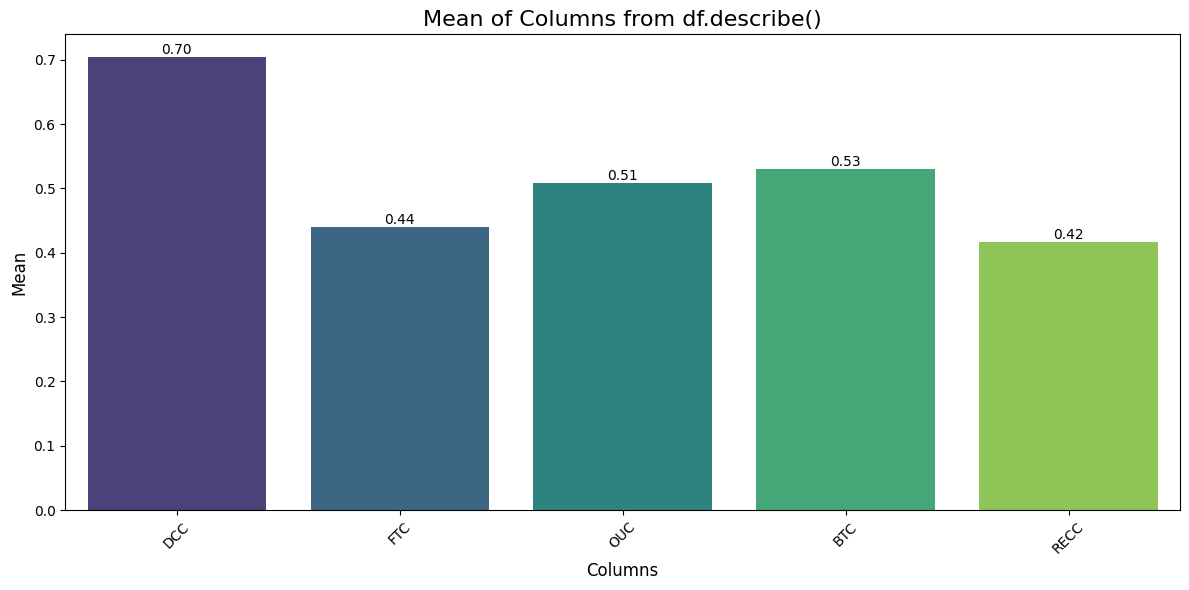

In [5]:
stats_df = combined_df[['League', 'Home', 'Away', 'DCC', 'FTC', 'OUC', 'BTC', 'RECC']]

import matplotlib.pyplot as plt
import seaborn as sns

# Get the summary statistics
desc = stats_df.describe()
print('Number of games: ', len(combined_df))

# Extract the 'mean' row
means = desc.loc['mean']

# Plotting the means using seaborn or matplotlib
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=means.index, y=means.values, palette="viridis")

# Add titles and labels
plt.title('Mean of Columns from df.describe()', fontsize=16)
plt.xlabel('Columns', fontsize=12)
plt.ylabel('Mean', fontsize=12)

# Rotate the x labels if necessary for better readability
plt.xticks(rotation=45)

# Add text labels to each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center',
                xytext=(0, 5),  # offset label from bar
                textcoords='offset points')

# Show the plot
plt.tight_layout()
plt.show()

# Finding Thresholds for the Model

In [6]:
import numpy as np

# Calculate the optimal threshold and best accuracy
def calculate_threshold(percentages, correctness):
    # Normalize the percentages to be between 0 and 1
    percentages = [p / 100 for p in percentages]

    best_threshold = 0
    best_accuracy = 0
    for threshold in np.unique(percentages):
        predicted_correctness = [1 if p >= threshold else 0 for p in percentages]
        accuracy = np.mean(np.array(predicted_correctness) == np.array(correctness))
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_threshold = threshold
    return round(best_threshold * 100, 2), round(best_accuracy * 100, 2)


print('Number of games: ', len(combined_df))
dc1x = combined_df[combined_df['DCBets'] == 'DC1X']
dc12 = combined_df[combined_df['DCBets'] == 'DC12']
dcx2 = combined_df[combined_df['DCBets'] == 'DCX2']

dc1x_t, dc1x_a = calculate_threshold(dc1x['DCPercent'], dc1x['DCC'])
dc12_t, dc12_a = calculate_threshold(dc12['DCPercent'], dc12['DCC'])
dcx2_t, dcx2_a = calculate_threshold(dcx2['DCPercent'], dcx2['DCC'])

print(f'DC1X threshold value: {dc1x_t}, accuracy: {dc1x_a}, games: {len(dc1x)}')
print(f'DC12 threshold value: {dc12_t}, accuracy: {dc12_a}, games: {len(dc12)}')
print(f'DCX2 threshold value: {dcx2_t}, accuracy: {dcx2_a}, games: {len(dcx2)}')
print(" ")

ft1 = combined_df[combined_df['FTRBets'] == 'FT1']
ftx = combined_df[combined_df['FTRBets'] == 'FTX']
ft2 = combined_df[combined_df['FTRBets'] == 'FT2']

ft1_t, ft1_a = calculate_threshold(ft1['FTRPercent'], ft1['FTC'])
ftx_t, ftx_a = calculate_threshold(ftx['FTRPercent'], ftx['FTC'])
ft2_t, ft2_a = calculate_threshold(ft2['FTRPercent'], ft2['FTC'])

print(f'FT1 threshold value: {ft1_t}, accuracy: {ft1_a}, games: {len(ft1)}')
print(f'FTX threshold value: {ftx_t}, accuracy: {ftx_a}, games: {len(ftx)}')
print(f'FT2 threshold value: {ft2_t}, accuracy: {ft2_a}, games: {len(ft2)}')
print(" ")

over_25 = combined_df[combined_df['2.5O/U'] == '2.5O']
under_25 = combined_df[combined_df['2.5O/U'] == '2.5U']

o25_t, o25_a = calculate_threshold(over_25['2.5Percent'], over_25['OUC'])
u25_t, u25_a = calculate_threshold(under_25['2.5Percent'], under_25['OUC'])

print(f'2.5Over threshold value: {o25_t}, accuracy: {o25_a}, games: {len(over_25)}')
print(f'2.5Under threshold value: {u25_t}, accuracy: {u25_a}, games: {len(under_25)}')
print(" ")

btts = combined_df[combined_df['BTTS'] == 'BTTS']
otts = combined_df[combined_df['BTTS'] == 'OTTS']

btts_t, btts_a = calculate_threshold(btts['BTPercent'], btts['BTC'])
otts_t, otts_a = calculate_threshold(otts['BTPercent'], otts['BTC'])

print(f'BTTS threshold value: {btts_t}, accuracy: {btts_a}, games {len(btts)}')
print(f'OTTS threshold value: {otts_t}, accuracy: {otts_a}, games {len(otts)}')

Number of games:  389
DC1X threshold value: 66.7, accuracy: 78.89, games: 180
DC12 threshold value: 67.34, accuracy: 66.36, games: 107
DCX2 threshold value: 67.75, accuracy: 59.8, games: 102
 
FT1 threshold value: 53.53, accuracy: 62.26, games: 212
FTX threshold value: 57.5, accuracy: 72.0, games: 50
FT2 threshold value: 86.14, accuracy: 64.57, games: 127
 
2.5Over threshold value: 55.68, accuracy: 56.82, games: 176
2.5Under threshold value: 67.96, accuracy: 55.4, games: 213
 
BTTS threshold value: 51.19, accuracy: 57.42, games 155
OTTS threshold value: 52.29, accuracy: 55.56, games 234
